## Installing MediaPipe

In [1]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 24.1 MB/s eta 0:00:00


## Configure Project path, Train and Test paths

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import glob

proj_path = '/content/drive/MyDrive/Magnimind/Face_detection/MP'
os.chdir(proj_path)

In [4]:
train_dir = os.path.join(proj_path, '..', 'train')
test_dir = os.path.join(proj_path, '..', 'test')

In [5]:
train_img_search_path = os.path.join(train_dir, '*')
train_img_paths = glob.glob(train_img_search_path)

test_img_search_path = os.path.join(test_dir, '*')
test_img_paths = glob.glob(test_img_search_path)

In [6]:
len(train_img_paths)

2080

In [7]:
len(test_img_paths)

300

## Visualize one image from train and test set

In [8]:
import random
random_train_img_path = random.choice(train_img_paths)
random_test_img_path = random.choice(test_img_paths)

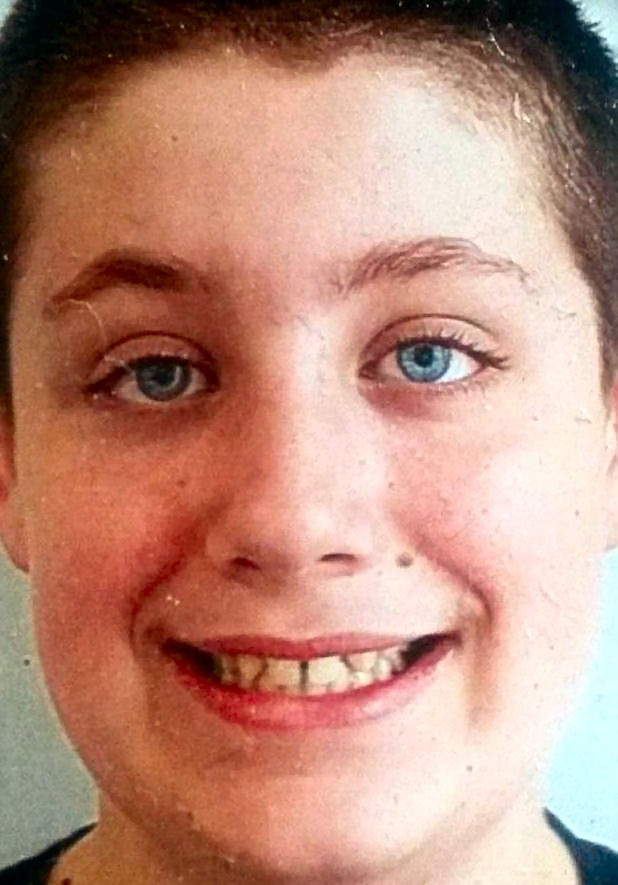

In [9]:
import cv2
from google.colab.patches import cv2_imshow

train_image = cv2.imread(random_train_img_path)
cv2_imshow(train_image)

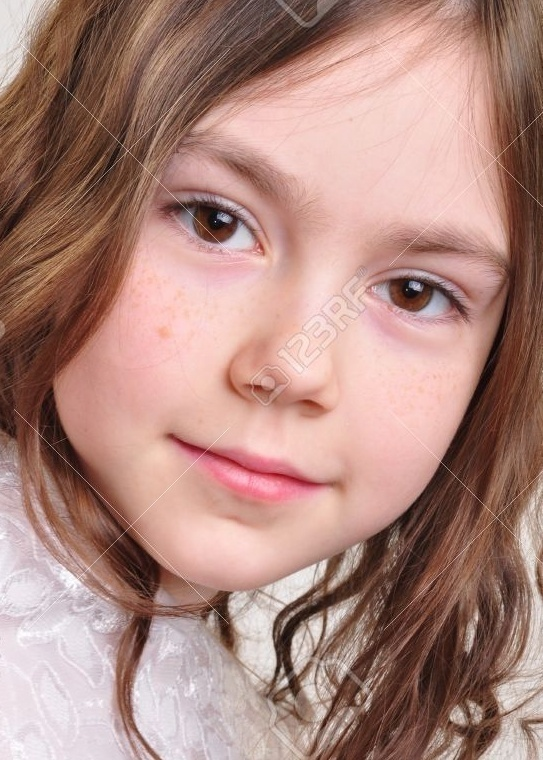

In [10]:
test_image = cv2.imread(random_test_img_path)
cv2_imshow(test_image)

In [11]:
import mediapipe as mp
import time

class FeatureExtractor:
    MAX_RETRIES = 5

    def __init__(self, img_dir=None):
        # Configuring image directory
        self.img_dir = img_dir
        self.img_paths = self._load_img_paths()

        # Initializing facemesh object
        self.face_mesh = mp.solutions.face_mesh.FaceMesh()

    def _load_img_paths(self):
        if self.img_dir == None:
            return None

        img_search_path = os.path.join(self.img_dir, '*')
        return glob.glob(img_search_path)

    def _extract_features_from_image(self, img_path):

        # Extract info from the image path
        file_name = os.path.basename(img_path)
        label, image_num_str, _ = file_name.split('.')
        image_num = int(image_num_str)

        # Read image and process it to detect face landmarks
        image = cv2.imread(img_path)

        # converting BGR to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image
        results = self.face_mesh.process(image)

        # No landmarks detected
        if not results.multi_face_landmarks:
            return None

        # Start collecting image features
        curr_img_feature = {
            "img_path": img_path,
            "image_num": image_num,
            "label": label
        }

        # Collect landmark features
        for landmarks in results.multi_face_landmarks:
            for idx, landmark in enumerate(landmarks.landmark):
                key_x = f"landmark_{idx}_x"
                key_y = f"landmark_{idx}_y"

                curr_img_feature[key_x] = landmark.x
                curr_img_feature[key_y] = landmark.y

        return curr_img_feature

    def get_features(self, img_paths=None):
        all_features = []

        if img_paths == None:
            img_paths = self.img_paths

        if img_paths == None:
            print('Configure the image path before extracting the features!')
            return None

        for img_path in img_paths:
            retries = 0
            while retries < self.MAX_RETRIES:
                features = self._extract_features_from_image(img_path)
                if features:
                    all_features.append(features)
                    break
                else:
                    print(f"Retry attempt {retries + 1}/{self.MAX_RETRIES} for image: {img_path}")
                    retries += 1
                    time.sleep(1)

            if retries >= self.MAX_RETRIES:
                print(f"Failed to detect facial landmarks for image: {img_path} after {self.MAX_RETRIES} retries")
        return all_features

In [12]:
train_extractor = FeatureExtractor(train_dir)
train_features = train_extractor.get_features()

test_extractor = FeatureExtractor(test_dir)
test_features = test_extractor.get_features()

Retry attempt 1/5 for image: /content/drive/MyDrive/Magnimind/Face_detection/MP/../train/Autistic.1130.jpg
Retry attempt 1/5 for image: /content/drive/MyDrive/Magnimind/Face_detection/MP/../train/Autistic.1129.jpg
Retry attempt 1/5 for image: /content/drive/MyDrive/Magnimind/Face_detection/MP/../train/Autistic.1134.jpg
Retry attempt 1/5 for image: /content/drive/MyDrive/Magnimind/Face_detection/MP/../train/Autistic.448.jpg
Retry attempt 1/5 for image: /content/drive/MyDrive/Magnimind/Face_detection/MP/../train/Autistic.5.jpg
Retry attempt 1/5 for image: /content/drive/MyDrive/Magnimind/Face_detection/MP/../train/Autistic.764.jpg


In [13]:
import pandas as pd
train_df = pd.DataFrame(train_features)
test_df = pd.DataFrame(test_features)

In [14]:
train_df.head()

,img_path,image_num,label,landmark_0_x,landmark_0_y,landmark_1_x,landmark_1_y,landmark_2_x,landmark_2_y,landmark_3_x,...,landmark_463_x,landmark_463_y,landmark_464_x,landmark_464_y,landmark_465_x,landmark_465_y,landmark_466_x,landmark_466_y,landmark_467_x,landmark_467_y
0,/content/drive/MyDrive/Magnimind/Face_detectio...,839,Autistic,0.511593,0.709910,0.517181,0.670308,0.515403,0.679123,0.500272,...,0.614458,0.486299,0.597307,0.492995,0.587559,0.500262,0.768636,0.474503,0.784336,0.468965
1,/content/drive/MyDrive/Magnimind/Face_detectio...,825,Autistic,0.566339,0.733220,0.575596,0.677747,0.568713,0.697361,0.553947,...,0.628819,0.549039,0.615948,0.553194,0.609449,0.556148,0.738344,0.541875,0.751471,0.531839
2,/content/drive/MyDrive/Magnimind/Face_detectio...,817,Autistic,0.437217,0.744490,0.426740,0.685478,0.433244,0.704711,0.405189,...,0.517382,0.542334,0.499661,0.547696,0.488665,0.551752,0.656447,0.535078,0.674554,0.525373
3,/content/drive/MyDrive/Magnimind/Face_detectio...,845,Autistic,0.533727,0.797597,0.549781,0.762331,0.540980,0.772093,0.528068,...,0.624055,0.614141,0.608973,0.618901,0.601406,0.623819,0.766676,0.603243,0.782729,0.596054
4,/content/drive/MyDrive/Magnimind/Face_detectio...,844,Autistic,0.524054,0.774706,0.505436,0.710976,0.512779,0.727149,0.466017,...,0.550516,0.553379,0.536100,0.562195,0.528307,0.568924,0.683886,0.525732,0.697740,0.517121


In [15]:
test_df.head()

,img_path,image_num,label,landmark_0_x,landmark_0_y,landmark_1_x,landmark_1_y,landmark_2_x,landmark_2_y,landmark_3_x,...,landmark_463_x,landmark_463_y,landmark_464_x,landmark_464_y,landmark_465_x,landmark_465_y,landmark_466_x,landmark_466_y,landmark_467_x,landmark_467_y
0,/content/drive/MyDrive/Magnimind/Face_detectio...,100,Autistic,0.727391,0.710138,0.753489,0.581854,0.723864,0.624057,0.699572,...,0.749237,0.411756,0.737767,0.418196,0.737665,0.421433,0.890724,0.401811,0.903891,0.394724
1,/content/drive/MyDrive/Magnimind/Face_detectio...,108,Autistic,0.457443,0.710929,0.437796,0.633989,0.445459,0.658974,0.401915,...,0.509359,0.460005,0.492417,0.466946,0.482040,0.471925,0.660659,0.437236,0.679693,0.424461
2,/content/drive/MyDrive/Magnimind/Face_detectio...,106,Autistic,0.452099,0.779923,0.453784,0.726497,0.455887,0.738631,0.441661,...,0.577733,0.505678,0.558054,0.512911,0.546055,0.521134,0.749610,0.499630,0.771000,0.490222
3,/content/drive/MyDrive/Magnimind/Face_detectio...,1,Autistic,0.457504,0.754957,0.470419,0.687706,0.467041,0.708499,0.457171,...,0.599581,0.529724,0.578473,0.532598,0.565713,0.535771,0.783299,0.529403,0.804902,0.522787
4,/content/drive/MyDrive/Magnimind/Face_detectio...,103,Autistic,0.362426,0.740446,0.366750,0.668341,0.372543,0.689162,0.377194,...,0.525101,0.542058,0.504449,0.543285,0.491366,0.545638,0.686309,0.559731,0.705237,0.556214


In [16]:
train_df.shape

(2080, 939)

In [17]:
test_df.shape

(300, 939)

In [18]:
train_df['label'].value_counts()

Autistic        1270
Non_Autistic     810
Name: label, dtype: int64

In [19]:
train_df['label'].value_counts(normalize=True)

Autistic        0.610577
Non_Autistic    0.389423
Name: label, dtype: float64

In [20]:
test_df['label'].value_counts()

Autistic        150
Non_Autistic    150
Name: label, dtype: int64

In [21]:
train_df[train_df.isna().any(axis=1)]

,img_path,image_num,label,landmark_0_x,landmark_0_y,landmark_1_x,landmark_1_y,landmark_2_x,landmark_2_y,landmark_3_x,...,landmark_463_x,landmark_463_y,landmark_464_x,landmark_464_y,landmark_465_x,landmark_465_y,landmark_466_x,landmark_466_y,landmark_467_x,landmark_467_y


In [22]:
train_df.to_csv('train_2D.csv', index=False)
test_df.to_csv('test_2D.csv', index=False)

## Visualizing key facial landmarks from train and test

In [23]:
import math
import numpy as np

# Convert relative to absolute coordinates
def convert_relative_to_absolute_coordinates(normalized_x, normalized_y, image_width, image_height):

    # Checks if the float value is between 0 and 1.
    def is_valid_normalized_value(value):
        return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

    if not (is_valid_normalized_value(normalized_x) and
            is_valid_normalized_value(normalized_y)):
        return None

    # Limiting the absolute co-ordinates value to width/height of the image
    x_px = min(math.floor(normalized_x * image_width), image_width - 1)
    y_px = min(math.floor(normalized_y * image_height), image_height - 1)

    return x_px, y_px

In [24]:
def visualize_output(img_path, landmarks):
    # Read Image
    image = cv2.imread(img_path)
    height, width, _ = image.shape

    for landmark in landmarks:
        landmark_px = convert_relative_to_absolute_coordinates(landmark[0], landmark[1], width, height)
        cv2.circle(image, landmark_px, 1, (255, 0, 0), -1)

    cv2_imshow(image)

In [25]:
def get_sample_image_and_landmarks(df):
    random_index = df.sample(1).index
    selected_row = df.loc[random_index].iloc[0]

    # Detect the number of landmarks based on the column names
    landmark_cols = [col for col in selected_row.index if "landmark_" in col and "_x" in col]
    num_landmarks = len(landmark_cols)
    print(f'Number of detected landmarks: {num_landmarks}')

    # Extract landmarks
    landmarks = [(selected_row[f'landmark_{i}_x'], selected_row[f'landmark_{i}_y']) for i in range(num_landmarks)]

    sample_img_path = str(selected_row['img_path'])

    return sample_img_path, landmarks

Number of detected landmarks: 468


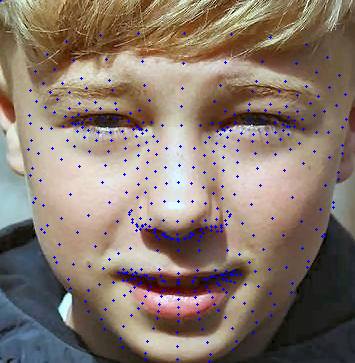

In [26]:
sample_train_img_path, landmarks = get_sample_image_and_landmarks(train_df)
visualize_output(sample_train_img_path, landmarks)

Number of detected landmarks: 468


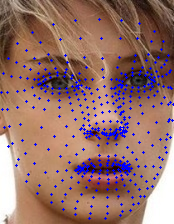

In [27]:
sample_test_img_path, landmarks = get_sample_image_and_landmarks(test_df)
visualize_output(sample_test_img_path, landmarks)